# Denoising Diffusion Probabilistic Models, CIFAR-10 dataset

In this notebook, we use the models, training and sampling code built out during the ddpm_mnist notebook to train a DDPM model on the CIFAR-10 dataset.

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# we already built out the UNet in the previous notebook
# so we import it from the src folder
from src.unet import UNet
from src.ddpm import train_model, sample_images
from src.utils import count_parameters

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(cifar10_full))
val_size = len(cifar10_full) - train_size
train_dataset, val_dataset = random_split(cifar10_full, [train_size, val_size])

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_loader = [(x.to(device), y.to(device)) for x, y in train_loader]
val_loader = [(x.to(device), y.to(device)) for x, y in val_loader]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


Files already downloaded and verified
Train dataset size: 40000
Validation dataset size: 10000
Number of training batches: 157
Number of validation batches: 40


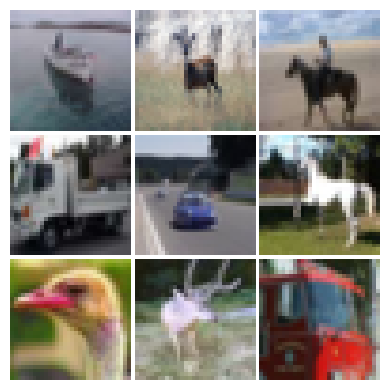

In [4]:

fig, axes = plt.subplots(3, 3, figsize=(4, 4))

for i in range(9):
    img, _ = train_dataset[i]
    row = i // 3
    col = i % 3
    
    img = img * 0.5 + 0.5  
    img = img.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()

In [6]:
model = UNet(
    down_filters=[64, 128, 256, 256], 
    in_channels=3, 
    num_layers=2, 
    has_attention=[False, True, True, True], 
    num_heads=4, 
    diffusion_steps=1000,
    num_groups=8, 
    activation=nn.SiLU, 
    dropout=0.1
).to(device)

print(f"The UNet model has {count_parameters(model):,} trainable parameters.")

lr = 6e-4
epochs = 100

optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs, eta_min=lr/100)
data_loaders = {'train': train_loader, 'valid': val_loader}
loss_fn = nn.MSELoss()
beta_schedule = torch.linspace(0.0001, 0.02, 1000).to(device)

train_loss, valid_loss = train_model(
    model=model,
    loaders=data_loaders,
    epochs=epochs,
    optim=optim,
    loss_fn=loss_fn,
    beta_schedule=beta_schedule,
    scheduler=scheduler,
    per_step_scheduler=True,
    checkpoint_every=10,
    checkpoint_name_prefix='ddpm_cifar_31M_6e_4'
)


The UNet model has 31,120,143 trainable parameters.
Epoch 0 of 100
Epoch 0, Train Loss: 0.25967733234546747, Valid Loss: 0.07424010382965207
Checkpoint saved at checkpoints/ddpm_cifar_31M_6e_4_epoch_1.pth
Epoch 1 of 100
Epoch 1, Train Loss: 0.11968375400752779, Valid Loss: 0.0637449855916202
Epoch 2 of 100
Epoch 2, Train Loss: 0.10350469822526738, Valid Loss: 0.053513941913843156
Epoch 3 of 100
Epoch 3, Train Loss: 0.09325822248200702, Valid Loss: 0.05315286228433251
Epoch 4 of 100
Epoch 4, Train Loss: 0.08661499106959933, Valid Loss: 0.05523512456566095
Epoch 5 of 100
Epoch 5, Train Loss: 0.08168590567104377, Valid Loss: 0.05322690391913056
Epoch 6 of 100


KeyboardInterrupt: 

In [12]:
sampled_images = sample_images(model, beta_schedule, 1000, device, image_shape=(3, 32, 32), num_samples=16)
sampled_images_cpu = sampled_images.cpu()

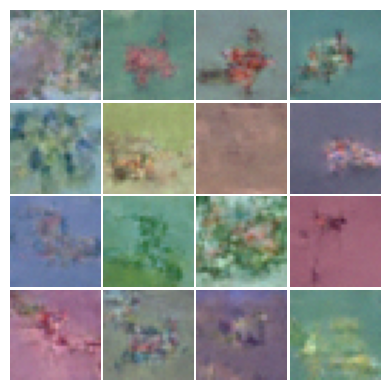

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(4, 4))

for i in range(16):
    img = sampled_images_cpu[i]
    row = i // 4
    col = i % 4
    
    img = img * 0.5 + 0.5  
    img = img.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()